## Catalog
<a href=#p0>0. Introduction</a>

<a href=#p1>1. Import Packages and Import Data</a>

<a href=#p2>2. EDA</a>

<a href=#p3>3. Text Cleaning </a>

<a href=#p4>4. Strategy 1: TF-IDF weighting + Boosting (XGBoost, LightGBM) and Bayes </a>

<a href=#p5>5. Strategy 2: GloVe Embedding + Neural Networks (LSTM)

<a href=#p6>6. Summary

<a name='p0' /></a>
## 0. Introduction
In this notebook, EDA and Data cleaning are carried out firstly. They do have some hints for the coming model construction process.

TF-IDF and GloVe are utilised for word vectorization, and XGB, LGB, and LSTM are adopted as algorithms.

Specifically, since LSTM model requires large amount of CPU and GPU resources, this notebook is carried on Google Colab to expedite the overall processing speed.

<a name='p1' /></a>
## 1. Import Packages and Import Data

This part mainly contains: 1. connections between Google Colab and Google Drive, 2. import packages, 3. import data

In [1]:
# This block is about building connections between Google Colab and personal google drive.
# Taken and amended from this stackoverflow answer: https://stackoverflow.com/questions/47744131/colaboratory-can-i-access-to-my-google-drive-folder-and-file
# I give full credits to the author.

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
import os
os.chdir("drive/Colab Notebooks/NLP") # in my personal google drive, I built a separate folder called "NLP" to store all related documents

In [3]:
# libraries involved

import numpy as np 
import pandas as pd
import re,string
import os
from datetime import datetime
from numpy import asarray

# Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Libs
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import TfidfVectorizer

# Additional Libs
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

# Deep Learning Libs
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

# other algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
# import data
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

In [5]:
# create a new column to encode the label
true_df['fake'] = 0
fake_df['fake'] = 1

In [6]:
mydf = pd.concat([true_df,fake_df],axis=0)
mydf['full_text'] = mydf['title'] + " " + mydf['text'] # the text I'm going to analyse is the combination of text and title

<a name='p2' /></a>
## 2. EDA

EDA is carried out basically for the following purpose: 1. check the class distribution (i.e. balance situation) of the dataset, 2. Check whether there should be some columns/features should be abolished which may act as confounding factors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


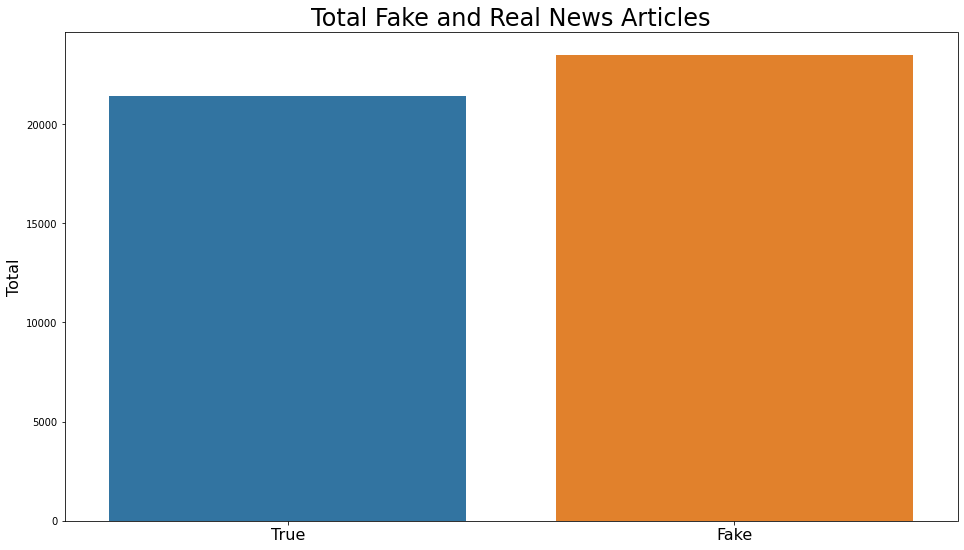

In [7]:
# check the sample distribution across classes
plt.figure(figsize=(16,9))
sns.countplot(mydf['fake'])
plt.title('Total Fake and Real News Articles', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([0, 1], ['True', 'Fake'], fontsize=16)
plt.show()

In [8]:
# check whether any missing value exists
mydf.isna().sum()

title        0
text         0
subject      0
date         0
fake         0
full_text    0
dtype: int64

In [9]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   fake       44898 non-null  int64 
 5   full_text  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB


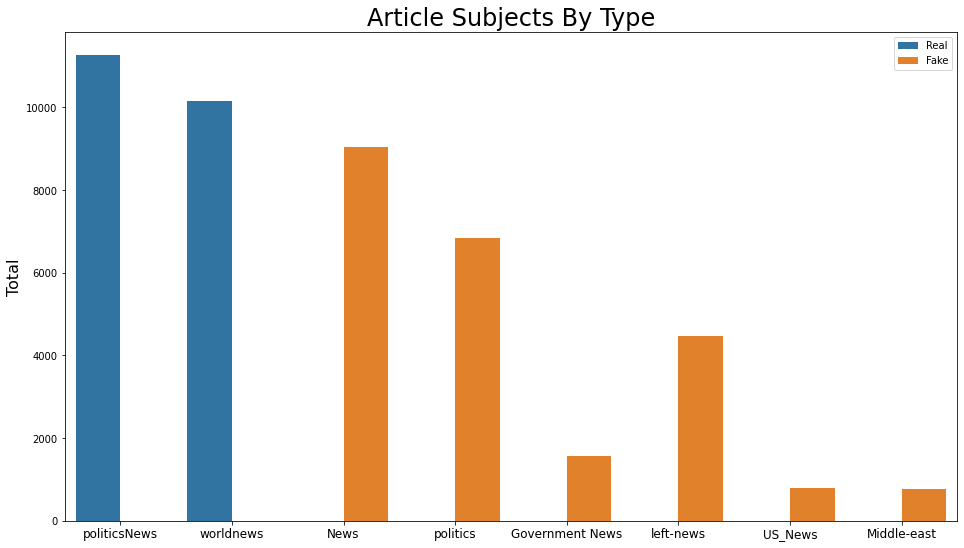

In [11]:
# check the sample distribution across different types in true/fake news
plt.figure(figsize=(16,9))
sns.countplot(x='subject', hue='fake', data=mydf)
plt.title('Article Subjects By Type', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.legend(['Real', 'Fake'])
plt.show()

Summary:

1.   There are 44,898 samples intotal, and the sample is **balanced**. True:False=0.91:1. Therefore, **no undersampling or oversampling techniques** are required.
2.   No missing values
3.  It is necessary to **rule out "subject" feature** in any further models. Since it can be perceived that as long as news are in the same subject, they have the same class. There is no heterogeneity observed.

<a name='p3' /></a>
## 3. Text Cleaning

This part mainly contains: 
1. data cleaning
2.     set random seed
3.  build time function to monitor time consumption

In [12]:
# in this part, I combine stopwords and punctuations into one list (stop_punct), in order to remove them all at once later on
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punct = list(string.punctuation)
stop_punct=stop.union(punct)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Since during EDA, I've noticed that some texts are actually urls, and **even some texts are in html forms** instead of normal text. Therefore, I think the right order of text cleaning should be: 
1.   Extract text from HTML (if applicable)
2.   Remove urls
3.   Remove characters other than letters
4. Convert all texts into lower case
5. Remove stopwords and punctuations
6. Stemming

In my following code, each points has been encapsulated into one function. Particularly, 5 and 6 are combined into one functions.






In [13]:
ps = PorterStemmer()

# Use beautiful soup to extract text from html document 
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', text)

# Removing the stopwords and punctuations from text, and also do stemming
def remove_stoppunct_stem(text):
    final_text = []
    for i in text.split():
        i_strip=i.strip()
        if i_strip not in stop_punct:
            final_text.append(ps.stem(i_strip))
            
    output_text=" ".join(final_text)
    corpus.append(output_text)
    return output_text

# function to clean the text
def clean_text(text):
    text = strip_html(text)
    text = remove_urls(text)
    text = re.sub('[^a-zA-Z]', ' ',text)
    text = text.lower()
    text = remove_stoppunct_stem(text)
    return text

In [14]:
# I constructed a time function to see how much time cost for some operations
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [15]:
corpus=[] # to store all the corpus

start_time_0 = timer(None)
mydf['full_text_clean']=mydf['full_text'].apply(clean_text) # full_text_clean is the clean version of text
timer(start_time_0)


 Time taken: 0 hours 4 minutes and 15.19 seconds.


In [16]:
seed=1 # set random seed to ensure repetability

In [17]:
X = mydf['full_text_clean']
y = mydf['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,stratify=y, random_state=seed) # train test split

<a name='p4' /></a>
## 4. Strategy 1: TF-IDF weighting + Boosting (XGBoost, LightGBM) and Bayes

This part mainly contains: 
1. TF-IDF vectorization (with some parameters imposed to limit the size)
2. XGB and LGBM based on TF-IDF

In [18]:
# Create the TF-IDF vectorizer
# bigrams and trigrams are adopted. Unigram is abolished since it might have not so much functions. 
# min_df and max_df: To ignore terms that have a document frequency lower than the min_df or greater than max_df.
tfidf=TfidfVectorizer(min_df=0.01,max_df=0.85,use_idf=True,ngram_range=(2,3))

# Transform train and test data
start_time_1 = timer(None) 
X_train_tfidf=tfidf.fit_transform(X_train) # only train data is used to fit the vectorizer
timer(start_time_1) 

# Transform the test dataset
start_time_2 = timer(None)
X_test_tfidf=tfidf.transform(X_test)
timer(start_time_2)

# covert to array to fit for algorithm's input requirements
X_train_tfidf.toarray() 
X_test_tfidf.toarray()


 Time taken: 0 hours 1 minutes and 27.02 seconds.

 Time taken: 0 hours 0 minutes and 6.68 seconds.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
xgb = XGBClassifier(random_state=seed) # here no hyperparameter tuning is carried out according to the instruction
start_time_3 = timer(None)
xgb.fit(X_train_tfidf, y_train)
timer(start_time_3)
y_xgb_pred = xgb.predict(X_test_tfidf)
print("XGBoost F1 and Accuracy Scores : \n")
print ("F1 score {:.4}".format(f1_score(y_test, y_xgb_pred)))
print ("Accuracy score {:.4}%".format(accuracy_score(y_test, y_xgb_pred)*100) )


 Time taken: 0 hours 0 minutes and 5.72 seconds.
XGBoost F1 and Accuracy Scores : 

F1 score 0.9314
Accuracy score 92.58%


In [22]:
lgbm = LGBMClassifier(random_state=seed)
start_time_6 = timer(None)
lgbm.fit(X_train_tfidf, y_train)
timer(start_time_6)
y_lgbm_pred = lgbm.predict(X_test_tfidf)
print("LGBM F1 and Accuracy Scores : \n")
print ("F1 score {:.4}".format(f1_score(y_test, y_lgbm_pred)))
print ("Accuracy score {:.4}%".format(accuracy_score(y_test, y_lgbm_pred)*100) )


 Time taken: 0 hours 0 minutes and 13.64 seconds.
LGBM F1 and Accuracy Scores : 

F1 score 0.965
Accuracy score 96.31%


<a name='p5' /></a>
## 5. Strategy 2: GloVe Embedding + Neural Networks (LSTM)

This part mainly contains: 
1. Word Tokenization and **padding (to fit for the uniform length requirement of sequence models like LSTM)**
2. **Import** GloVe **and fit** GloVe in this project to generate final embedding matrix 
3. Use GloVe embedding matrix to construct LSTM sequence model

*Due to the long time running of LSTM model, I have intentionally control the magnitude of some parameters (e.g. epochs only 5) to limit the time consumed. 

In [23]:
max_features = 500 # select the vocabularies that ranks first 500 places. To get the most precise model, this parameter should be larger than 500
max_len=1000

start_time_4 = timer(None)
tokenizer = Tokenizer(num_words=max_features) # create tokenizer
tokenizer.fit_on_texts(X_train.values)

# Padding the vectors of different lengths to the vectors with same length, i.e. max_len=1000
tokenizer_train=tokenizer.texts_to_sequences(X_train)
X_train_token=sequence.pad_sequences(tokenizer_train,maxlen=max_len)

tokenizer_test=tokenizer.texts_to_sequences(X_test)
X_test_token=sequence.pad_sequences(tokenizer_test,maxlen=max_len)
timer(start_time_4)


 Time taken: 0 hours 0 minutes and 13.01 seconds.


GloVe is another efficient method to do vectorization apart from TF-IDF. I have self-downloaded the pre-trianed word vectors from [Stanford NLP GloVe website](https://nlp.stanford.edu/projects/glove/). Here I use the one with only 50 dimensions to expedite the training speed. However, 200d, 300d are definitely preferred to get the best model.

In [24]:
# This block is about importing and processing the GloVe document
# Taken and amended from kaggle: https://www.kaggle.com/breenda/feature-engineering#Feature-Engineering-on-News-Body:
# I give full credits to the author.
embeddings_index = dict()
start_time_5 = timer(None)
f = open('glove.6B.50d.txt', encoding="utf8") # utf-8 should be included to parse and open the document in the right way
# this block is to load the whole embedding into memory, including each word and it's relative coefficients
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
timer(start_time_5)

Loaded 400000 word vectors.

 Time taken: 0 hours 0 minutes and 10.21 seconds.


In [25]:
# create a weight matrix for words in training corpus

# here begin to officially create the embedding matrix

# Here, the total length of the text-based dictionary is Len (word_index). 
# However, since the max_feature is used for filtering, the final dictionary used is actually determined by the minimal between max_feature and Len (word_index)
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) 

embedding_matrix = np.zeros((nb_words, 50)) # the embedding dimension is 50d since I'm using 50d version
for word, i in word_index.items():
    if i >= max_features: continue # If i is greater than max_feature, the word is out of the max_feature range and does not need to be processed
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [26]:
# now define the LSTM model
model = Sequential()
# For embedding layer, "trainable" denotes whether the weight of that layer can be changed. 
# Since here the weight of the embedding layer is actually from pre-trained GloVe model, so I set trainable attribute set to False
model.add(Embedding(nb_words, 50, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3)) # dropout to prevent overfitting 
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid')) # sigmoid is to control the range of output between [0,1]
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          25000     
_________________________________________________________________
dropout (Dropout)            (None, 1000, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 85,501
Trainable params: 60,501
Non-trainable params: 25,000
_________________________________________________________________
None


In [27]:
# fit the model
# here I've applied earlystopping technique in order to prevent overfitting as well as to save the training time.
monitor=EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True)
start_time_7 = timer(None)
model.fit(X_train_token, y_train, epochs=5, verbose=1,callbacks=[monitor],validation_data=(X_test_token, y_test))
timer(start_time_7)

Epoch 1/5
983/983 [==============================] - 765s 775ms/step - loss: 0.3126 - accuracy: 0.8710 - val_loss: 0.1952 - val_accuracy: 0.9284
Epoch 2/5
983/983 [==============================] - 833s 847ms/step - loss: 0.2132 - accuracy: 0.9232 - val_loss: 0.0737 - val_accuracy: 0.9796
Epoch 3/5
983/983 [==============================] - 832s 847ms/step - loss: 0.2374 - accuracy: 0.9086 - val_loss: 0.1859 - val_accuracy: 0.9380
Epoch 4/5
983/983 [==============================] - 834s 849ms/step - loss: 0.1886 - accuracy: 0.9342 - val_loss: 0.0549 - val_accuracy: 0.9864
Epoch 5/5
983/983 [==============================] - 829s 844ms/step - loss: 0.0764 - accuracy: 0.9788 - val_loss: 0.0196 - val_accuracy: 0.9953

 Time taken: 1 hours 8 minutes and 14.27 seconds.


In [28]:
model.save(r"LSTM_model") # save the model

INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


In [30]:
y_lstm_pred = model.predict_classes(X_test_token)
print("LSTM F1 and Accuracy Scores : \n")
print ("F1 score {:.4}".format(f1_score(y_test, y_lstm_pred)))
print ("Accuracy score {:.4}%".format(accuracy_score(y_test, y_lstm_pred)*100) )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


LSTM F1 and Accuracy Scores : 

F1 score 0.9955
Accuracy score 99.53%


<a name='p6' /></a>
## 6. Summary
1. This dataset does have some characteristics that are important for constructing the model. For example, need to deal with html documents and urls, the subject feature is actually useless etc.

2. Reasons to select TF-IDF and GloVe:


> TF-IDF considers both term frequency in the document (TF) and also the rarity (or importance) of term in the whole corpus (IDF). It can be calculated very quickly and in a more reasonable way.


> One biggest disadvantage of TF-IDF is that it fails to capture the context information. GloVe embedding as a sequence vectorization method is able to record the context information and input in sequence models like LSTM.

3. Reasons to select Boosting and LSTM:


> Boosting is able to get better model by learning from the faliures of previous classifiers and combine multiple classifiers to form a stronger one. 

I choose boosting methods (XGB and LGBM) to compete with LSTM is because I think it represents the best performance that **traditional** ML classifiers can achieve.
> LSTM is better to handle sequence data like text without having the problem of gradient vanishing/exploidng like RNN. I choose it as a representation of NN. 


4. In terms of model assessment, I think it can be divided into the following parts:

**Time consumption:** 

> LSTM (68 min. for only 5 epochs....) + GloVe vectorization (less than 1 min.) = 69 min.


> TF-IDF (1.5 min.) + XGB (5s) + LGBM (13s) = 2 min. 

However, in my notebook some of the parameters have been controlled to save the time. It can be estimated that when practically carrying out a grid search for model tuning, time consumption of LSTM will be much larger than the other two.

**Space used:** Obviously, since GloVe uses global information of the corpus, it takes more memories than TF-IDF. And LSTM also has much more parameters to be estimated than boosting methods.

**Performance:**
> F1: LSTM (0.9955) > LGBM (0.965) > XGB (0.9314)

> Accuracy: LSTM (99.53%) > LGBM (96.31%) > XGB (92.58%)

LSTM do perform better than traditional traditional boosting method. However, I think if we hyperparameter tuning is carried out, maybe boosting can also reach the same level.

**In a nutshell,** for this specific case, TF-IDF + traditional boosting methods are better, because of short time consumption, limited memory space utilised, the acceptable performance